<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

Dask user installation:
``` bash
python3 -m pip install --upgrade "dask[complete]"
```
or system-wide installation:
``` bash
sudo -H python3 -m pip install --upgrade "dask[complete]"
```
[Dask](https://dask.org/) documentation.

## Dask delayed

In [1]:
from dask import delayed, compute
import dask

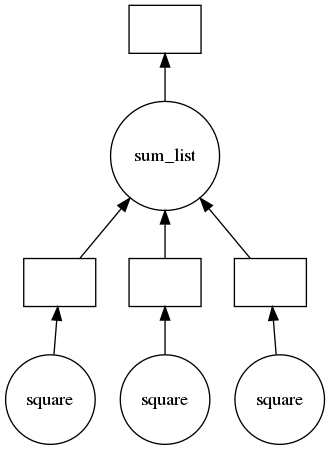

In [2]:
@delayed
def square(num):
    print("square fn:", num)
    print()
    return num * num

@delayed
def sum_list(args):
    print("sum_list fn:", args)
    return sum(args)

items = [1, 2, 3]

computation_graph = sum_list([square(i) for i in items])

computation_graph.visualize()

In [3]:
print("Result", computation_graph.compute())

square fn: 1

square fn: 3

square fn: 2

sum_list fn: [1, 4, 9]
Result 14


## Embarrassingly parallel applications

In [4]:
from dask.distributed import Client, progress
# client = Client(threads_per_worker=2, n_workers=1)
client = Client('tcp://10.31.210.110:8786')
client

Client Scheduler: tcp://10.31.210.110:8786 Dashboard: http://10.31.210.110:8787/status,Cluster Workers: 1 Cores: 32 Memory: 135.15 GB


In [5]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [6]:
%time costly_simulation([1, 2, 3, 4])

CPU times: user 1.32 ms, sys: 0 ns, total: 1.32 ms
Wall time: 245 ms


10

In [7]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,param_a,param_b,param_c,param_d
0,0.733335,0.330497,0.947224,0.941222
1,0.144997,0.923813,0.255806,0.171603
2,0.648229,0.437616,0.190016,0.724842
3,0.380301,0.851717,0.082619,0.022251
4,0.713062,0.594238,0.483827,0.447726


In [8]:
results = []

In [9]:
%%time
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

CPU times: user 13.6 ms, sys: 2.62 ms, total: 16.2 ms
Wall time: 4.79 s


In [10]:
results

[2.95227751174819,
 1.4962206260056763,
 2.000703717304197,
 1.3368871553996207,
 2.238852226059198,
 1.2246869202460755,
 1.5150677879246899,
 2.474446182300221,
 1.1436989152126984,
 1.1077956736359411]

## Using dask delayed

In [11]:
import dask
lazy_results = []

In [12]:
%%time

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

CPU times: user 40.6 ms, sys: 8.94 ms, total: 49.5 ms
Wall time: 64 ms


In [13]:
lazy_results[0]

Delayed('costly_simulation-fef00f3d-aec0-480b-a727-da43ad239eaa')

In [14]:
%time dask.compute(*lazy_results)

CPU times: user 593 ms, sys: 238 ms, total: 830 ms
Wall time: 10.4 s


(2.95227751174819,
 1.4962206260056763,
 2.000703717304197,
 1.3368871553996207,
 2.238852226059198,
 1.2246869202460755,
 1.5150677879246899,
 2.474446182300221,
 1.1436989152126984,
 1.1077956736359411,
 1.6860452847181806,
 1.8681672258413462,
 2.5395615828406557,
 2.0414427614248294,
 2.3765486645213025,
 1.5662046137856964,
 1.9772914906661183,
 1.8650521962666429,
 1.9718459500219707,
 2.0512701522848102,
 1.6836806302859315,
 0.7605114539300184,
 2.709522857376867,
 1.417899908734348,
 1.8045774375904091,
 3.1522052784400922,
 2.4335987512660076,
 2.519468473080398,
 0.94033703941981,
 2.44560812186216,
 0.674281099922539,
 1.1553575144742085,
 2.828069344886871,
 2.9473727827712812,
 2.0498052343483333,
 2.2818431596545485,
 2.2603613240755576,
 2.5279076431370613,
 2.6978375159466155,
 1.2916273001010425,
 1.6912861716595364,
 2.520651274450147,
 1.7543463129639874,
 2.987586475119261,
 1.9336086711376785,
 1.864345959490553,
 2.5560646750635656,
 2.180659422786803,
 1.1759266

### or run in background

In [15]:
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

### and get results later

In [16]:
results = dask.compute(*futures)
results[:5]

(2.95227751174819,
 1.4962206260056763,
 2.000703717304197,
 1.3368871553996207,
 2.238852226059198)

## Using Futures API

In [17]:
# this starts the jobs right away
futures = client.map(costly_simulation, input_params.values)

In [18]:
# get the results later
results = client.gather(futures)
len(results)

500

In [19]:
results[:5]

[2.95227751174819,
 1.4962206260056763,
 2.000703717304197,
 1.3368871553996207,
 2.238852226059198]